# Propensity Score Matching

In many cases, we are interested in assessing the effectiveness of a campaign or other types of treatments. For example, let's assume we are interested in evaluating the impact of a **demand-response programme** on the electricity consumption of a set of households. Suppose that households can join the demand-response programme by filling out a specific form. For those who join, the programme offers reduced pricing during off-peak hours. Our goal is to assess the effectiveness of this programme by comparing the electricity consumption of people who joined the programme (our **treatment group**) to those who did not (our **control group**).

In an ideal scenario, if we were able to conduct a completely randomised experiment, we would have a balanced and diverse set of customers in both groups. In such a situation, if the possibility of joining the programme was as random as flipping a coin, any significant differences in consumption patterns between the two groups could be attributed to the special pricing offered by the programme.

However, in real life, things are more complicated. Because people are not randomly assigned to the two groups, there may be characteristics of the people who voluntarily joined the programme that are the true causes of changes in consumption. For example, if a majority of the people who agreed to join the programme are retired, it is likely that they will use electricity during off-peak hours due to their lifestyle and not solely because of the reduced pricing. This is an example of **selection bias**.

Whenever the treatment and control assignment is not random, there may be demographic or personal factors that affect the outcome of the experiment. These factors are referred to as **confounders**. This problem is particularly prevalent in observational data (see {cite}`rosenbaum1983central`).

**Propensity score matching (PSM)** is a statistical technique used to estimate the effect of a treatment by accounting for covariates that predict receiving the treatment {cite}`caliendo2008some`. In our case, this means we can try to estimate the effect of the demand-response programme by considering the covariates that might have influenced who joined the programme. Essentially, if we can estimate the probability of someone joining the programme based on demographic factors, we can **match** treated and untreated subjects with similar propensity scores. By comparing these matched groups, we can compute an adjusted difference that helps mimic a randomised experimental design, reducing selection bias and allowing for a more accurate estimation of the treatment effect.

In mathematical terms, we can define the propensity score $e(x)$ as the probability of a unit (e.g., customer) joining the demand-response programme given a set of covariates $x$:
\begin{equation}
   e(x) = P(T = 1 \mid X = x)
\end{equation}

where $T$ is a binary indicator of treatment assignment (1 if joined the programme, 0 if not).


Propensity scores are typically estimated using **logistic regression**, although other classification methods can be used. For example:
\begin{equation}
   \hat{e}(x) = \hat{P}(T = 1 \mid X = x) = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p))}
\end{equation}

After estimating the propensity scores, we can proceed with the matching process. There are several ways to perform matching {cite}`austin2014comparison`, such as:

1. **Nearest-neighbor matching**: each treated unit is matched with the control unit that has the closest propensity score.
2. **Caliper matching**: similar to nearest-neighbor matching but with a tolerance level (caliper) for how close the propensity scores must be.
3. **Stratification (or interval matching)**: units are divided into strata based on their propensity scores, and comparisons are made within each stratum.
4. **Kernel matching**: Weights all control units according to their distance from the treated unit's propensity score.

## Example
Let's walk through an example using Python to illustrate how to implement propensity score matching, estimate the treatment effect, and visualize the results. 

We will use a synthetic dataset to simulate our scenario. Suppose our dataset includes the following columns:
- `joined_program`: A binary indicator (1 if joined the program, 0 if not).
- `peak_consumption`: The electricity consumption of the household during peak hours.
- `age`: Age of the household head.
- `income`: Income level of the household.
- `household_size`: Number of members in the household.

We also introduce some **bias in the treatment assignment** to simulate a real-world scenario where older people are more likely to join the programmw and lower-income households are less likely to join.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

np.random.seed(0)
n = 1000
age = np.random.normal(50, 12, n).astype(int)
income = np.random.normal(50000, 15000, n).astype(int)
household_size = np.random.randint(1, 6, n)

# Bias in treatment assignment
noise = np.random.normal(0, 10, n)
prob_join = 1 / (1 + np.exp(-(0.5 * age - 0.0001 * income + 0.2 * household_size - 5 + noise)))
joined_program = (np.random.rand(n) < prob_join).astype(int)

peak_consumption = (200 - 0.001 * income + 0.2 * household_size - 2 * joined_program + np.random.normal(0, 1, n))

data = pd.DataFrame({
    'joined_program': joined_program,
    'peak_consumption': peak_consumption,
    'age': age,
    'income': income,
    'household_size': household_size
})


data.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,joined_program,peak_consumption,age,income,household_size
0,1,140.595562,71,58339,3
1,1,134.926546,54,63387,2
2,1,154.885678,61,43665,4
3,1,147.252513,76,51570,1
4,1,146.337150,72,53420,1


### Propensity Scores Estimation
In this step, we use logistic regression to estimate the propensity scores, which represent the probability of joining the programme given the covariates (age, income, and household size).

In [2]:
covariates = ['age', 'income', 'household_size']
X = data[covariates]
y = data['joined_program']

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
data['propensity_score'] = log_reg.predict_proba(X)[:, 1]

data.head()

,joined_program,peak_consumption,age,income,household_size,propensity_score
0,1,140.595562,71,58339,3,0.994963
1,1,134.926546,54,63387,2,0.959616
2,1,154.885678,61,43665,4,0.988158
3,1,147.252513,76,51570,1,0.997573
4,1,146.337150,72,53420,1,0.995956


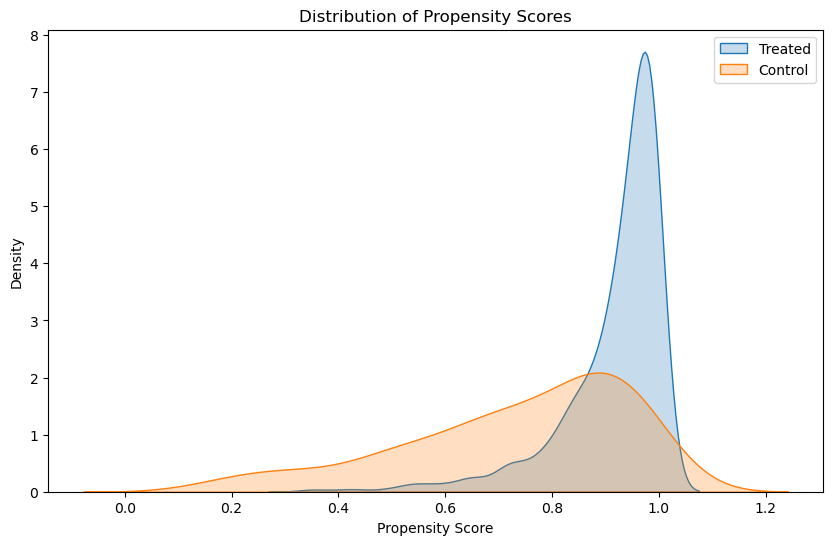

In [3]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data['propensity_score'][data['joined_program'] == 1], label='Treated', fill=True)
sns.kdeplot(data['propensity_score'][data['joined_program'] == 0], label='Control', fill=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In this plot, the extent to which the treated and control **propensity score distributions overlap** is crucial:
- Significant overlap indicates that for many households, there are comparable counterparts in both groups, which is good for matching.
- Minimal overlap suggests that there are many treated households with no comparable controls (or vice versa), which can be problematic for matching.


Before matching, it is common to see differences in the distributions, especially if certain covariates strongly influence whether households join the program. The initial (pre-matching) plot might show that the treated group has higher propensity scores on average, indicating that those who joined the program had characteristics that made them more likely to join. This bias is what matching aims to adjust for by finding control units with similar propensity scores.

### Nearest-Neighbor Matching

We separate the treated (joined the program) and control (did not join the program) groups. Using the nearest-neighbor matching technique, we match each treated unit with the control unit that has the closest propensity score. The goal here is to match each treated unit (household that joined the programme) with one or more control units (households that did not join the programme) that have similar propensity scores. Here's a detailed explanation of how we can do it:
- We separate the treated and control groups based on whether they joined the program or not.
- We find the closest control units for each treated unit based on their propensity scores.
- We combine the treated units and their matched control units into a single dataset for further analysis.

In [4]:
# Step 3: Perform Matching
treated = data[data['joined_program'] == 1]
control = data[data['joined_program'] == 0]

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nbrs.kneighbors(treated[['propensity_score']])

# Get the matched control units
matched_control_indices = indices.flatten()
matched_control = control.iloc[matched_control_indices]

matched_pairs = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)], axis=1)
matched_pairs.columns = ['t_' + col if i < len(treated.columns) else 'c_' + col for i, col in enumerate(matched_pairs.columns)]

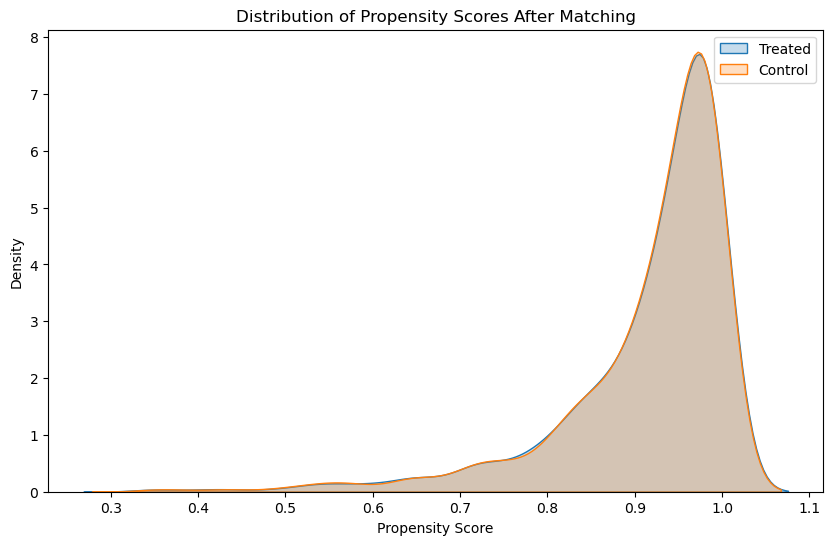

In [5]:
# Distribution of propensity scores after matching
plt.figure(figsize=(10, 6))
sns.kdeplot(matched_pairs['t_propensity_score'], label='Treated', fill=True)
sns.kdeplot(matched_pairs['c_propensity_score'], label='Control', fill=True)
plt.title('Distribution of Propensity Scores After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

As we see here, after matching, we ideally want the distributions to overlap substantially, indicating that the treated and control groups are similar with respect to the covariates used to estimate the propensity scores. 

### Treatment Effect Estimation

We calculate the Average Treatment Effect on the Treated (ATT) by comparing the average electricity consumption of the treated group to that of the matched control group.

In [6]:
treatment_effect = matched_pairs['t_peak_consumption'].mean() - matched_pairs['c_peak_consumption'].mean()
print(f'Estimated Treatment Effect: {treatment_effect:.3f} KWh')

Estimated Treatment Effect: -2.583 KWh


### Results

We can create some visualisations to compare the distributions of propensity scores and electricity consumption before and after matching.

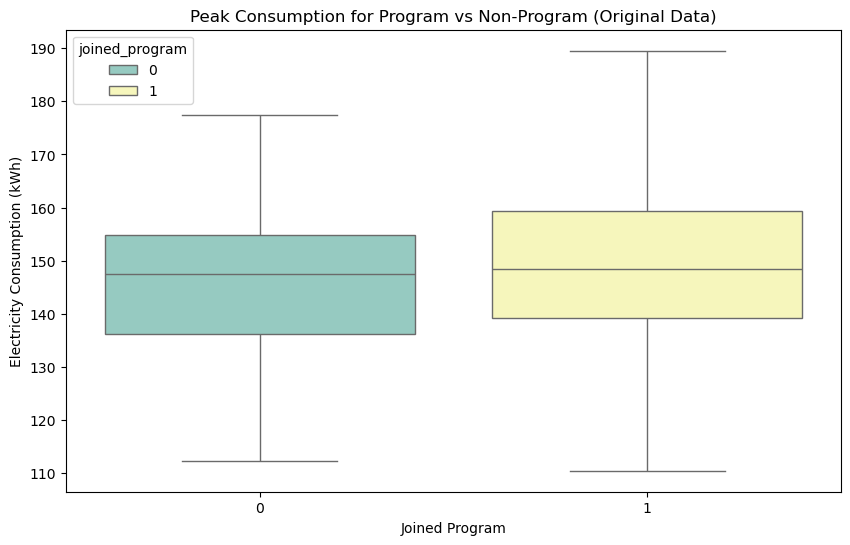

In [7]:
# Electricity consumption before and after matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='joined_program', y='peak_consumption', data=data, palette='Set3', hue='joined_program', showfliers=False)
plt.title('Peak Consumption for Program vs Non-Program (Original Data)')
plt.xlabel('Joined Program')
plt.ylabel('Electricity Consumption (kWh)')
plt.show()

We can see how, looking at the original data, we would get the impression that people who joined the programme consume more lectricity during peak hours. The situation is much different when we look at the consumptions for the matched groups, where we see that joining the programme actually has a positive effect in reducing electricity consumption during peak hours.

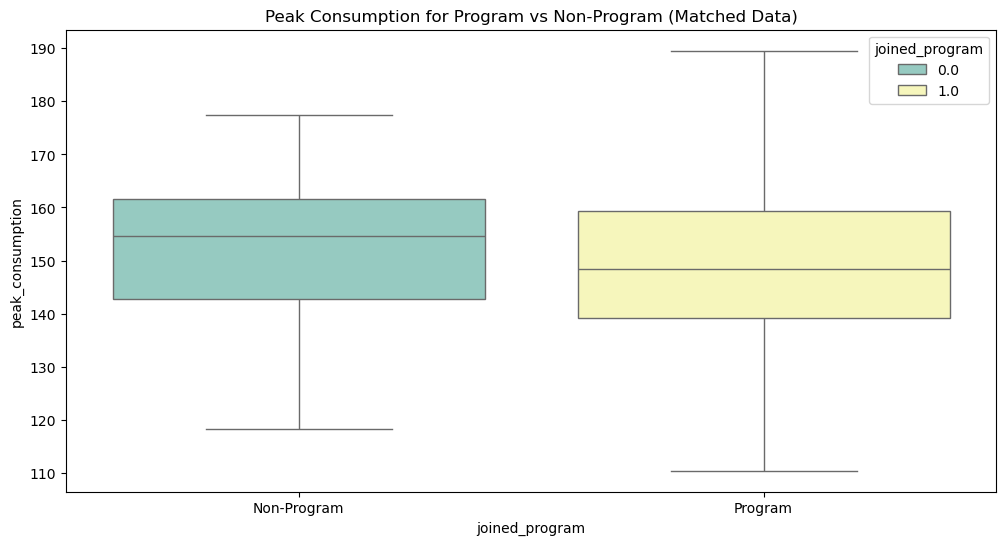

In [8]:
# Violin plot of consumption for matched data
# Boxplot of consumption for matched data
matched_data = pd.DataFrame({
    'joined_program': np.concatenate([np.ones(len(matched_pairs)), np.zeros(len(matched_pairs))]),
    'peak_consumption': np.concatenate([matched_pairs['t_peak_consumption'], matched_pairs['c_peak_consumption']])
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='joined_program', y='peak_consumption', data=matched_data, palette='Set3', hue='joined_program', showfliers=False)
plt.title('Peak Consumption for Program vs Non-Program (Matched Data)')
plt.xticks([0, 1], ['Non-Program', 'Program'])
plt.show()




This example demonstrates the basic steps of performing propensity score matching and evaluating the treatment effect. By matching treated and control units with similar propensity scores, we reduce the bias due to confounding variables and can make a more accurate assessment of the treatment's impact.